In [2]:
#packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Problem 1:
Task one Generate a training set based on the Lorentz system:

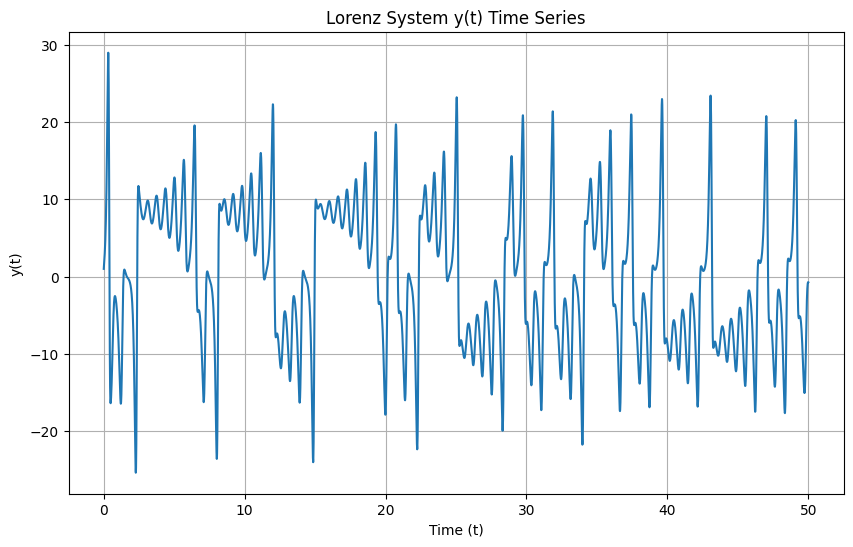

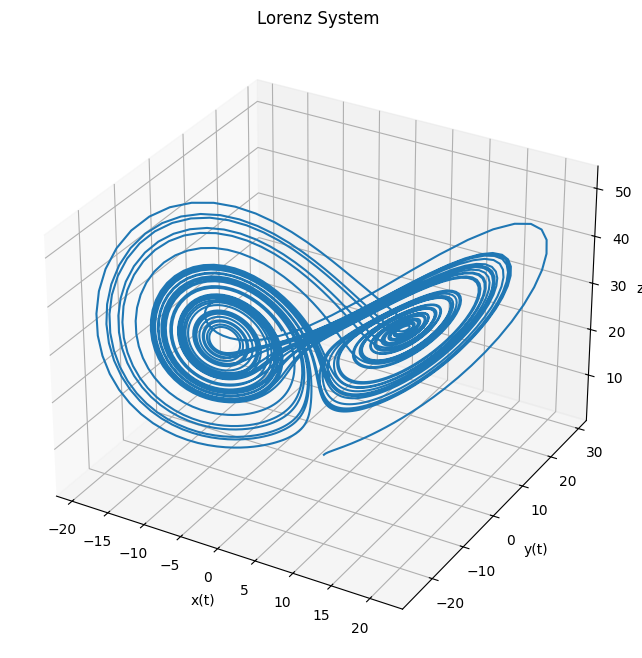

In [3]:
sigma = 10
b = 8/3
r = 28
dt = 0.01
T = 50
N = int(T/ dt)
z= np.zeros(N)
x= np.zeros(N)
y= np.zeros(N)
x[0] = 1
y[0] = 1
z[0] = 1



for t in range(N-1):
    x[t+1] = x[t] + (-sigma*x[t] + sigma*y[t])*dt
    y[t+1] = y[t] + (-x[t]*z[t] + r*x[t] - y[t])*dt
    z[t+1] = z[t] + (x[t]*y[t] - b*z[t])*dt

t = np.linspace(0, T, N)

np.savetxt("training-set.csv", y, delimiter=",")

training_data = np.stack((x, y, z), axis=-1)

np.savetxt("training-set-comp.csv", training_data, delimiter=",")


plt.figure(figsize=(10, 6))
plt.plot(t, y)
plt.title('Lorenz System y(t) Time Series')
plt.xlabel('Time (t)')
plt.ylabel('y(t)')
plt.grid(True)
plt.show()



fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_title('Lorenz System')
ax.set_xlabel('x(t)')
ax.set_ylabel('y(t)')
ax.set_zlabel('z(t)')
plt.show()


## Problem 2:
Set up a reservoir based on Equation 1:

using Ridge regression resulting in:

𝐖𝑜𝑢𝑡= train_data·𝐑̃^𝑇 * (𝐑̃·𝐑̃^𝑇 + 𝛽.𝐈)^−1,

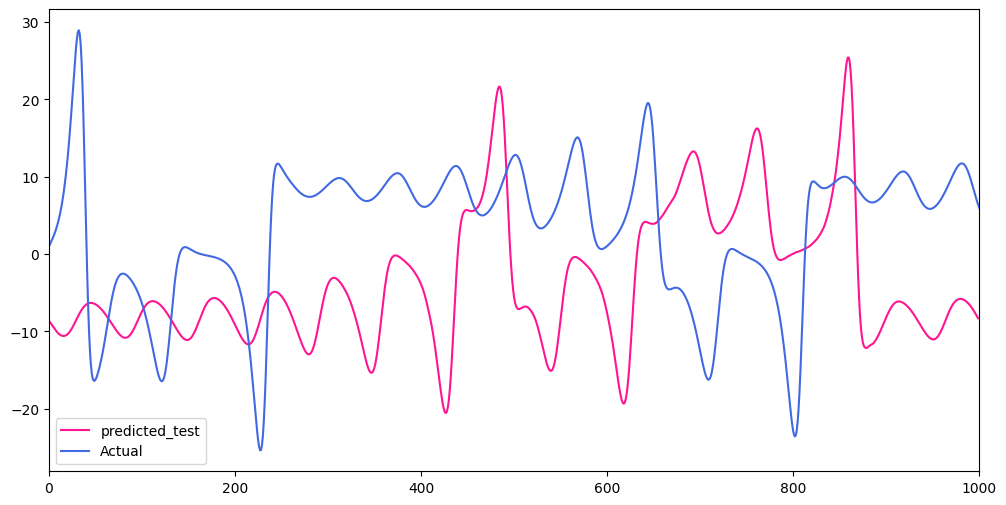

In [4]:

training_file = 'training-set.csv'
training_data_c = np.loadtxt(training_file, delimiter=',', dtype=np.float32)

split_ind = int(0.80 * len(training_data_c))
training_data = training_data_c[:split_ind]
test_data = training_data_c[split_ind:]

#the number of input neurons depends on the number of time series and it should match with the dimentionality of input data.
input_neurons = 1
reservoir_neurons = 500
alpha = 0.01

def train_y(training_data,test_data):
    
    reservoir_weight = np.random.normal(0, (2/800)**0.5, size=(reservoir_neurons, reservoir_neurons))
    input_weight = np.random.normal(0, 0.002**0.5, size=(reservoir_neurons))

    num_pattern = len(training_data)
    r = np.zeros((num_pattern, reservoir_neurons))
    for t in range(0, num_pattern-1):
        r[t+1] = np.tanh(np.dot(reservoir_weight, r[t]) + np.dot(input_weight, training_data[t]))
        
    output_weight = np.dot( np.linalg.inv(np.dot(r.T, r) + alpha * np.identity(reservoir_neurons)),np.dot(r.T, training_data.T))
    # output_weight = np.dot(np.linalg.pinv(r), training_data)
    output = np.zeros(len(training_data))  

    for t in range(len(training_data)):
        output[t] = np.dot(output_weight, r[t])
    
    test_length = len(test_data)
    output2 = np.zeros(len(test_data)) 
    r_test = np.zeros((test_length, reservoir_neurons))
    r_test[0] = r[-1]
    output2[0] = np.dot(output_weight, r[-1])

    for t in range(0, test_length-1):
        temp2 = np.dot(input_weight, output2[t])
        temp1 = np.dot(reservoir_weight, r_test[t])
        r_test[t+1] = np.tanh(temp1 + temp2)
        output2[t+1] = np.dot(output_weight, r_test[t+1])
    
    return output2, output
p, output = train_y(training_data,test_data)
# print(p, "out")
plt.figure(figsize=(12, 6)) 
plt.plot(p, label='predicted_test', c="deeppink",)
plt.plot(training_data, label='Actual', c="royalblue")
plt.xlim(0, 1000)
plt.legend()
plt.show()

## Problem 3:


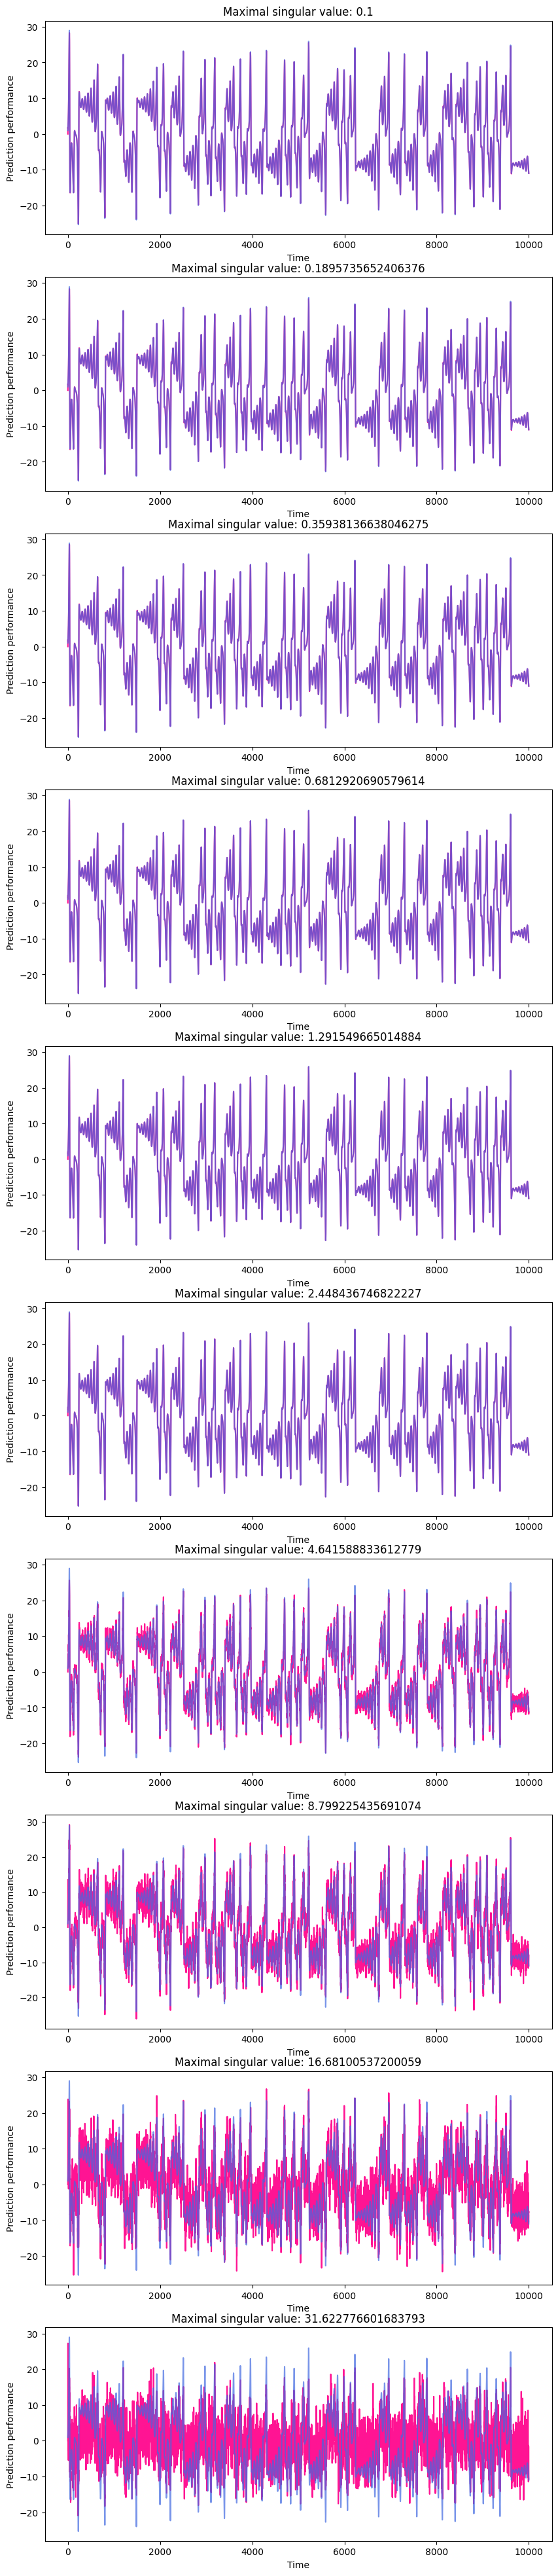

In [47]:
training_file = 'training-set.csv'
training_data = np.loadtxt(training_file, delimiter=',', dtype=np.float32)
#the number of input neurons depends on the number of time series and it should match with the dimentionality of input data.

reservoir_neurons = 500
alpha = 0.1
#initialization (reservoir weight and output weight)
W = np.random.normal(0, (2/500)**0.5, size=(reservoir_neurons, reservoir_neurons))
input_weight_y = np.random.normal(0, 0.002**0.5, size=(reservoir_neurons))

def train_evaluate(training_data, max_singular_value):
    U, s, Vt = np.linalg.svd(W)
    s = s / np.max(s) * max_singular_value
    reservoir_weight = U @ np.diag(s) @ Vt

    num_pattern_y = len(training_data)
    r_y = np.zeros((num_pattern_y, reservoir_neurons))

    for t in range(0, num_pattern_y-1):
        r_y[t+1] = np.tanh(np.dot(reservoir_weight, r_y[t]) + np.dot(input_weight_y, training_data[t]))
        
    output_weight_y = np.dot(np.dot(r_y.T, training_data), np.linalg.inv(np.dot(r_y.T, r_y) + alpha * np.identity(reservoir_neurons)))

    predictions_y = np.dot(r_y, output_weight_y)
    
    mse = np.mean((predictions_y - training_data)**2)
    return mse, predictions_y
    

# max_singular_values = np.linspace(0.1, 10, 10)  
max_singular_values = np.logspace(-1, 1.5, 10)  
performances = []
fig, axs = plt.subplots(len(max_singular_values), 1, figsize=(10, 5*len(max_singular_values)))

for i, max_singular_value in enumerate(max_singular_values):
  
    mse , predictions_y = train_evaluate(training_data, max_singular_value)
    performances.append(mse)
    # print(performance)
    axs[i].plot(predictions_y, label='Predicted', c='deeppink')
    axs[i].plot(training_data, label='Actual', alpha=0.7, c='royalblue')
    axs[i].set_title(f'Maximal singular value: {max_singular_value}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Prediction performance')


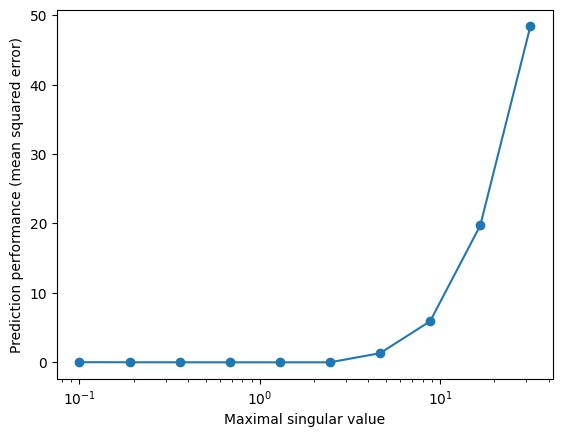

In [49]:
plt.tight_layout()
plt.plot(max_singular_values, performances, '-o')
plt.xscale('log')
plt.xlabel('Maximal singular value')
plt.ylabel('Prediction performance (mean squared error)')
plt.show()

Almost after 2.5 we can see that the mean squared error increases which means that  
the reservoir computation can not predict the Lorenz system good enough.

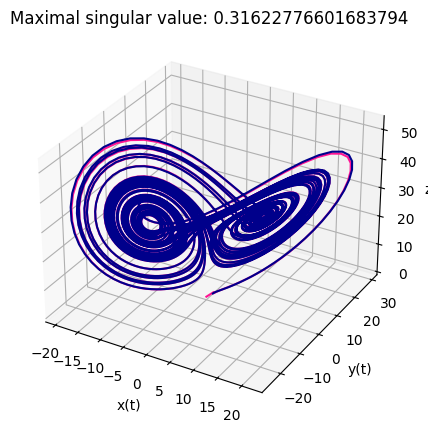

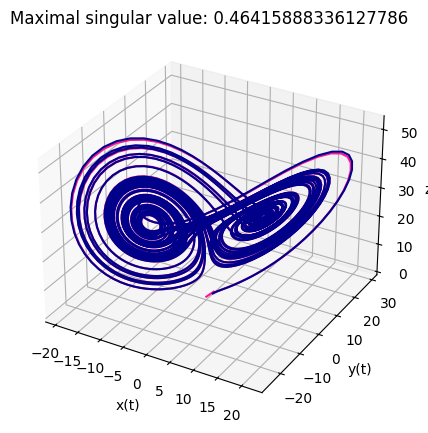

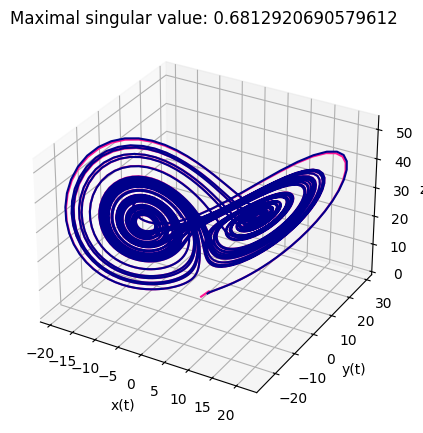

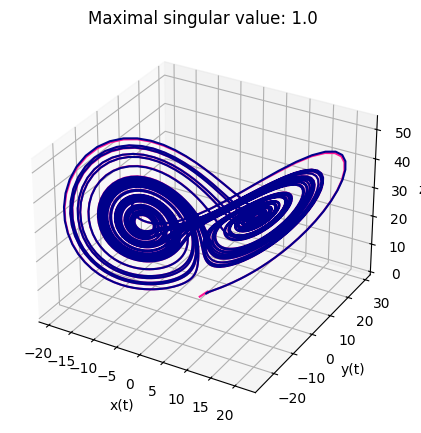

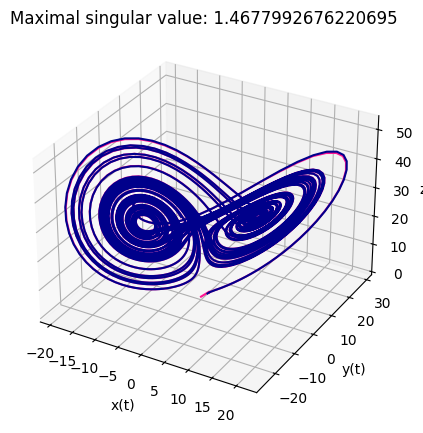

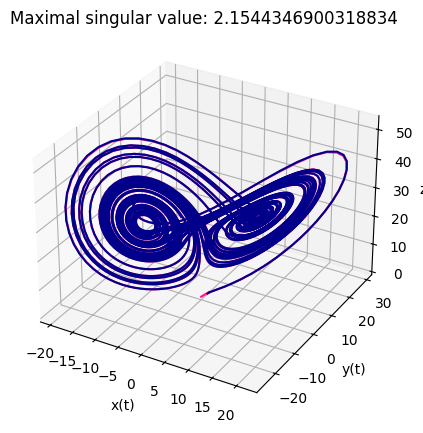

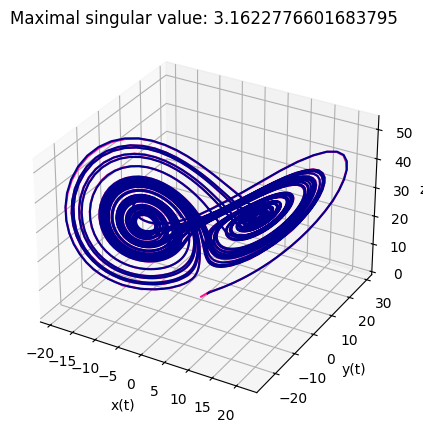

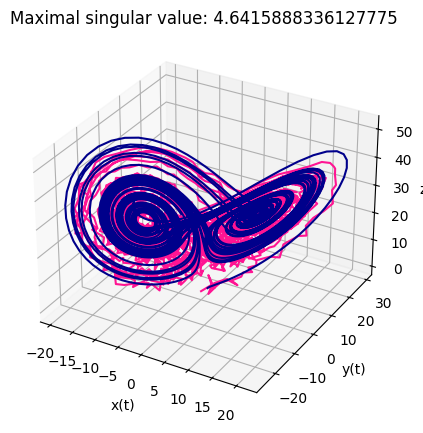

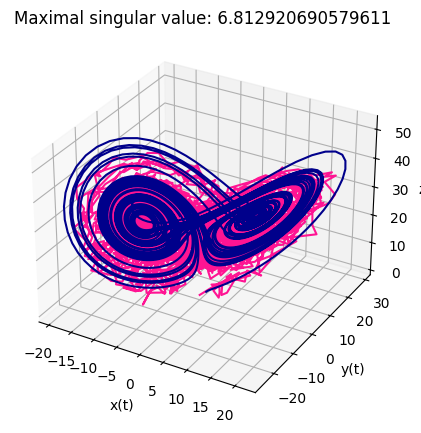

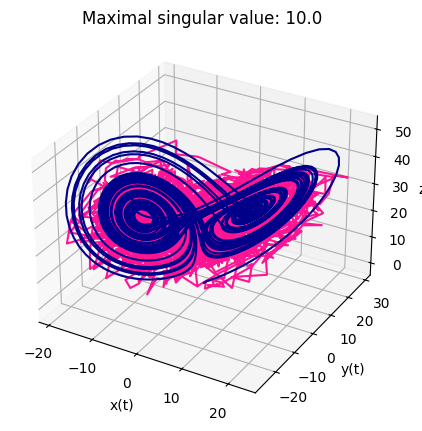

In [7]:
training_file_com = "training-set-comp.csv" 
training_data_com = np.loadtxt(training_file_com, delimiter=',', dtype=np.float32)

input_neurons = 3
reservoir_neurons = 500
alpha = 0.1
input_weight_com = np.random.normal(0, 0.002**0.5, size=(reservoir_neurons, input_neurons))
W = np.random.normal(0, (2/500)**0.5, size=(reservoir_neurons, reservoir_neurons))


num_patterns = len(training_data_com)
r_com = np.zeros((num_patterns, reservoir_neurons))

def train_evaluate(training_data_com, max_singular_value):
    U, s, Vt = np.linalg.svd(W)
    s = s / np.max(s) * max_singular_value
    reservoir_weight_com = U @ np.diag(s) @ Vt

    for t in range(0, num_patterns-1):
        r_com[t+1,:] = np.tanh(np.dot(reservoir_weight_com, r_com[t,:]) + np.dot(input_weight_com, training_data_com[t, :]))


#  np.dot(np.dot(r_com.T, training_data_com), np.linalg.inv(np.dot(r_com.T, r_com) + alpha * np.identity(reservoir_neurons)))
    output_weight_com = np.dot(
        np.linalg.inv(np.dot(r_com[1:, :].T, r_com[1:, :]) + alpha * np.identity(reservoir_neurons)),
        np.dot(r_com.T, training_data_com)
    )

    predictions_com = np.dot(r_com, output_weight_com)
    mse = np.mean((predictions_com - training_data_com)**2)
    return mse, predictions_com
    

# max_singular_values = np.linspace(0.1, 10, 10)  
max_singular_values = np.logspace(-0.5, 1, 10)  
performances = []


for i, max_singular_value in enumerate(max_singular_values):
  
    mse , predictions_com = train_evaluate(training_data_com, max_singular_value)
    performances.append(mse)
    # print(performance)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(predictions_com[:, 0], predictions_com[:, 1], predictions_com[:, 2], label='Predicted In 3 Dimensions (X, Y, Z)', c='deeppink')
    ax.plot(training_data_com[:, 0], training_data_com[:, 1], training_data_com[:, 2], label='Predicted In 3 Dimensions (X, Y, Z)', c='darkblue')
    ax.set_xlabel('x(t)')
    ax.set_ylabel('y(t)')
    ax.set_zlabel('z(t)')
    ax.set_title(f'Maximal singular value: {max_singular_value}')
    plt.show()
    
# Compute Mean Squared Error
# mse = np.mean((predictions_com - training_data_com)**2)
# print("Mean Squared Error:", mse)




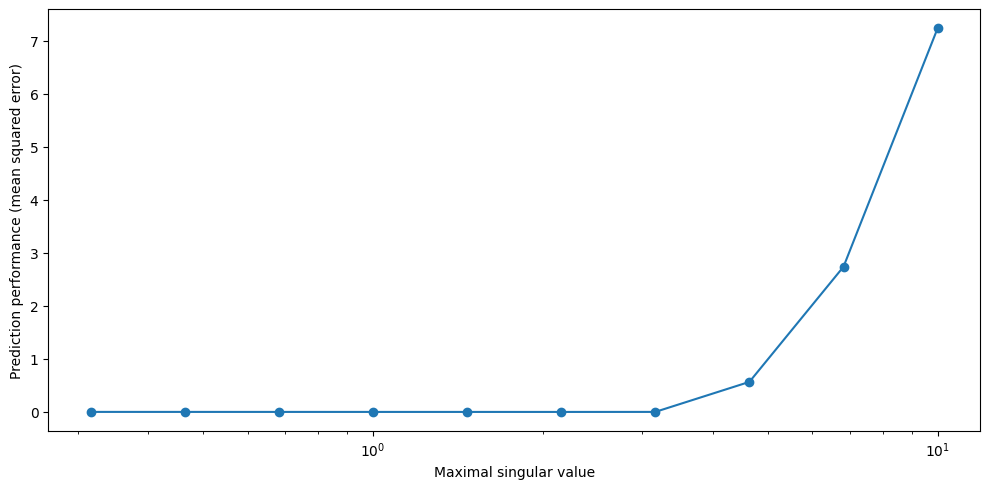

In [56]:
plt.figure(figsize=(10, 5))
plt.plot(max_singular_values, performances, '-o')
plt.xscale('log')
plt.xlabel('Maximal singular value')
plt.ylabel('Prediction performance (mean squared error)')
plt.tight_layout()
plt.show()

In 3 dimentions the reservoir computation works well before value 3.3 of singular value, but after this value is start to predict correctly

## Problem 4

1.9288589620179901 is lambda1 value
51 Lyapunov times with a mean squared error of 0.02239540838976984.


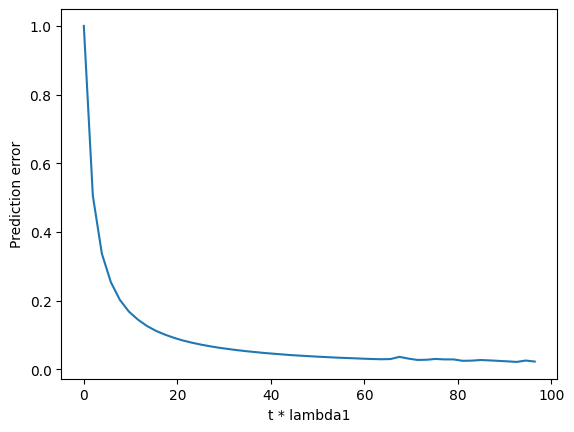

In [68]:
from sklearn.metrics import mean_squared_error
x1, y1, z1 = 1.0, 1.0, 1.0
x2, y2, z2 = 1.0, 1.0, 1.0001
sigma = 10
b = 8/3
r = 28
dt = 0.01
N = 10000

sum_log = 0

for t in range(N-1):
    x1, y1, z1 = (
        x1 + (-sigma*x1 + sigma*y1)*dt,
        y1 + (-x1*z1 + r*x1 - y1)*dt,
        z1 + (x1*y1 - b*z1)*dt
    )
    x2, y2, z2 = (
        x2 + (-sigma*x2 + sigma*y2)*dt,
        y2 + (-x2*z2 + r*x2 - y2)*dt,
        z2 + (x2*y2 - b*z2)*dt
    )
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

    log_divergence = np.log(distance)
    sum_log += log_divergence

lambda1 = sum_log/N

print(f"{lambda1} is lambda1 value")

num_lyapunov_times = int(N * dt / lambda1)

predicted_y = train_y(training_data[:num_lyapunov_times])

error = mean_squared_error(training_data[:num_lyapunov_times], predicted_y)

print(f"{num_lyapunov_times} Lyapunov times with a mean squared error of {error}.")


errors = np.zeros(num_lyapunov_times)
for i in range(num_lyapunov_times):
    predicted_y = train_y(training_data[:i+1])
    error = mean_squared_error(training_data[:i+1], predicted_y)
    errors[i] = error

t = np.arange(num_lyapunov_times)
plt.plot(t * lambda1, errors)
plt.xlabel('t * lambda1')
plt.ylabel('Prediction error')
plt.show()

